In [1]:
import numpy as np
import matplotlib.pyplot as plt

import maxflow
from selectpoints import select_k_points as select_k_points

## 3. Segmentation with Markov Random Fields

In this problem you will build an MRF model for interactively
segmenting an image into foreground/background and use an st-mincut solver to
find the MAP assignment of pixels to foreground and background.

We will use PyMaxflow which implements the mincut solver. You can find some 
tutorial documentation here:  http://pmneila.github.io/PyMaxflow/tutorial.html

You will need write code that loads in an image and computes the appropriate
weights between neighboring pixels as well as the edge connections to the s and
t nodes.  

Your code should display the image and prompt the user to click on two seed
points for foreground and background. I've provided a functionn to allow this
in your notebook (**selectpoints.py**).

You should use these seed points to do two things.  First, use the color of 
the pixels in the vicinity of the two points to initialize the foreground and 
background color models. Second, set the st-connections so that these seed points
are constrained to be in the foreground and background of the final
solution (i.e., give them large weights)

Build a model in which the foreground and background are assumed to
be constant color.  Your st edges should have weights which are proportional to
the distance in RGB between the pixel and your foreground or background color.
Connections between neighbors should be proportional to the difference in
color between neighboring pixels.  There is a free parameter $\lambda$ in eqn
1 of the paper by Boykov \& Jolly paper (linked on the course website) that controls
the relative importance of the st edges and the neighbor edges in the graph.
You will want to experiment to find a setting of this parameter that gives you
a good segmentation result for the test image.

## 3.1 Implementation

In [2]:
#[x] load an image

#[x] interactively choose terminal points

#[x] use color of pixels in vicinity to initialize the foreground and background color models. assume foreground and 
# background are constant color.

#[x] initialize 'K' - weights of seed points to a really high value

#[x] st-links should have weights proportional to the distance (in RGB) between pixel and backgrounf or foregrounf color

#[x] n-links should have weights proportional to difference in color between neighboring pixels

#[x] free parameter \lambda - controls relative importance of st-links and n-links

In [3]:
def pixel_wise_dist(x,y):
    return np.sqrt(np.sum((y-x)**2, axis=2))

In [4]:
def binary_segmentation(image, obj_seed_point, bkg_seed_point, K, s, LAMBDA):
    m, n, _ = image.shape
    
    # mean foreground pixel value
    obj_x = obj_seed_point[0] #column 
    obj_y = obj_seed_point[1] #row
    object_patch = image[obj_y-10:obj_y+10, obj_x-10:obj_x+10]
    obj_meanR = np.mean(object_patch[:,:,0])
    obj_meanG = np.mean(object_patch[:,:,1])
    obj_meanB = np.mean(object_patch[:,:,2])
    obj_mean = np.array([obj_meanR, obj_meanG, obj_meanB])

    # mean background pixel value
    bkg_x = bkg_seed_point[0] #column 
    bkg_y = bkg_seed_point[1] #row
    background_patch = image[bkg_y-10:bkg_y+10, bkg_x-10:bkg_x+10]
    bkg_meanR = np.mean(background_patch[:,:,0])
    bkg_meanG = np.mean(background_patch[:,:,1])
    bkg_meanB = np.mean(background_patch[:,:,2])
    bkg_mean = np.array([bkg_meanR, bkg_meanG, bkg_meanB])
    
    # following same notation as paper
    Rp_obj = -np.log(pixel_wise_dist(image, obj_mean)/(pixel_wise_dist(image, obj_mean)+pixel_wise_dist(image, bkg_mean)+1e-6))
    Rp_bkg = -np.log(pixel_wise_dist(image, bkg_mean)/(pixel_wise_dist(image, obj_mean)+pixel_wise_dist(image, bkg_mean)+1e-6))
    
    # initialize graph, object seed as source and background seed as sink
    g = maxflow.Graph[float](m,n)
    nodeids = g.add_grid_nodes((m,n))
    
    # set all st-links
    g.add_grid_tedges(nodeids, LAMBDA*Rp_obj, LAMBDA*Rp_bkg)
    
    # set seed capacities
    g.add_tedge(nodeids[obj_seed_point[1],obj_seed_point[0]], K, 0) 
    g.add_tedge(nodeids[bkg_seed_point[1],bkg_seed_point[0]], 0, K)
    
    # set n-links
    # TODO - slide and euclidean distance; efficient implementation w/o for 
    for i in range(m):
        for j in range(n):
            if i!=0 & j!=0: #non-border pixels
                w_top = np.exp(-np.linalg.norm(image[i,j]-image[i-1,j])/s**2)
                g.add_edge(nodeids[i,j], nodeids[i-1,j], w_top, w_top)

                w_left = np.exp(-np.linalg.norm(image[i,j]-image[i,j-1])/s**2)
                g.add_edge(nodeids[i,j], nodeids[i,j-1], w_left, w_left)

            if i==0:
                if j!=n-1:
                    w_right = np.exp(-np.linalg.norm(image[i,j]-image[i,j+1])/s**2)
                    g.add_edge(nodeids[i,j], nodeids[i,j+1], w_right, w_right)

            if j==0:
                if i!=0:
                    w_top = np.exp(-np.linalg.norm(image[i,j]-image[i-1,j])/s**2)
                    g.add_edge(nodeids[i,j], nodeids[i-1,j], w_top, w_top)
                    
    # get maxflow
    g.maxflow()
    segments = g.get_grid_segments(nodeids)
    binary_segmentation = np.int_(np.logical_not(segments))
    
    return binary_segmentation

## 3.2 Testing & Visualization

Show segmentations produced from the test images **segtest1.jpg** and 
**segtest2.jpg**. Also show results on at least one other image of your
choice. Use the {\tt plot} command to plot 'x's on the original image 
indicating where your seed points were for each example.  Comment on 
the successes and failures of this approach.

<IPython.core.display.Javascript object>


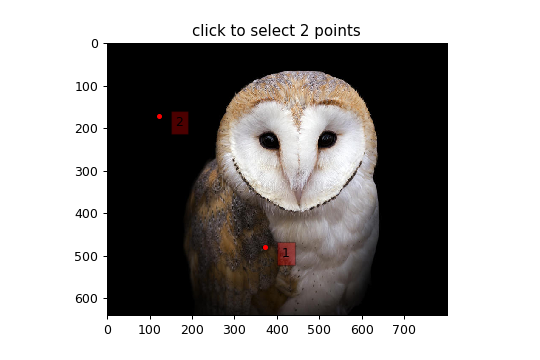

offset= 40.0


In [23]:
# load image
image = plt.imread('owl.jpg')

%matplotlib notebook
fig = plt.figure()
ax = fig.add_subplot(1,1,1) 
ax.imshow(image,cmap=plt.cm.gray)

#selectpoints will show the axis and wait for the specified # number of user clicks
k=2
spoints = select_k_points(ax,k)

C:\Users\chinm\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:24: RuntimeWarning: divide by zero encountered in log


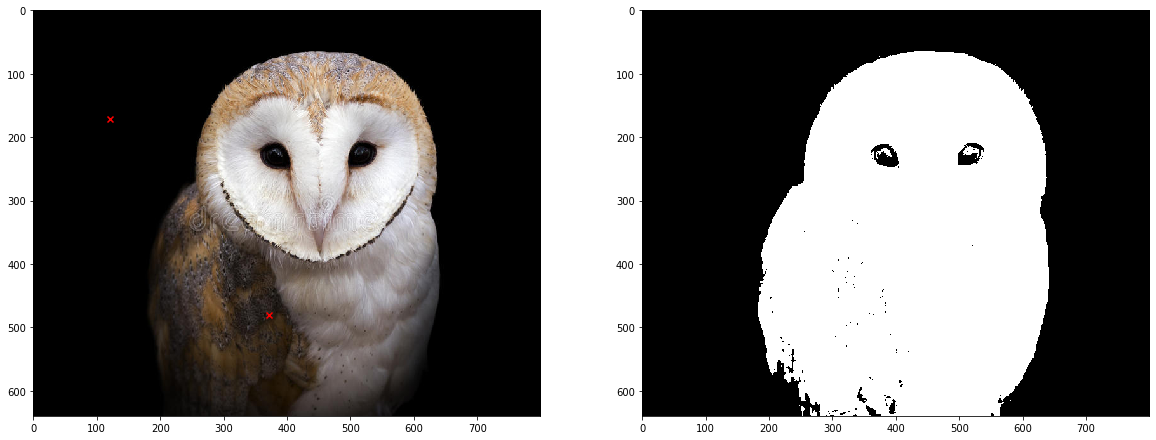

In [24]:
xp = spoints.xs
yp = spoints.ys

obj_seed_point = (int(xp[0]), int(yp[0]))
bkg_seed_point = (int(xp[1]), int(yp[1]))

segmentation = binary_segmentation(image, obj_seed_point, bkg_seed_point, K=10e4, s=0.9, LAMBDA=40)

%matplotlib inline
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.imshow(image)
plt.scatter(x=[obj_seed_point[0], bkg_seed_point[0]], y=[obj_seed_point[1], bkg_seed_point[1]], c='r', marker='x')

plt.subplot(1,2,2)
plt.imshow(segmentation, cmap='gray')

<IPython.core.display.Javascript object>


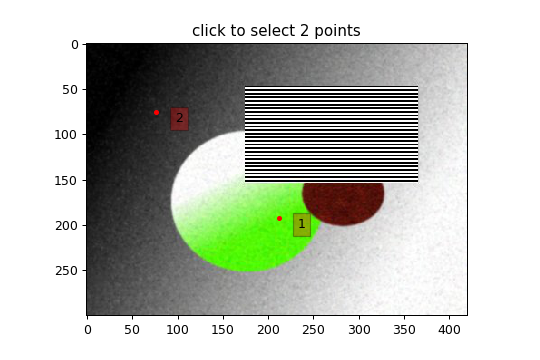

offset= 21.0


In [19]:
# load image
image = plt.imread('segtest1.jpg')

%matplotlib notebook
fig = plt.figure()
ax = fig.add_subplot(1,1,1) 
ax.imshow(image,cmap=plt.cm.gray)

#selectpoints will show the axis and wait for the specified # number of user clicks
k=2
spoints = select_k_points(ax,k)

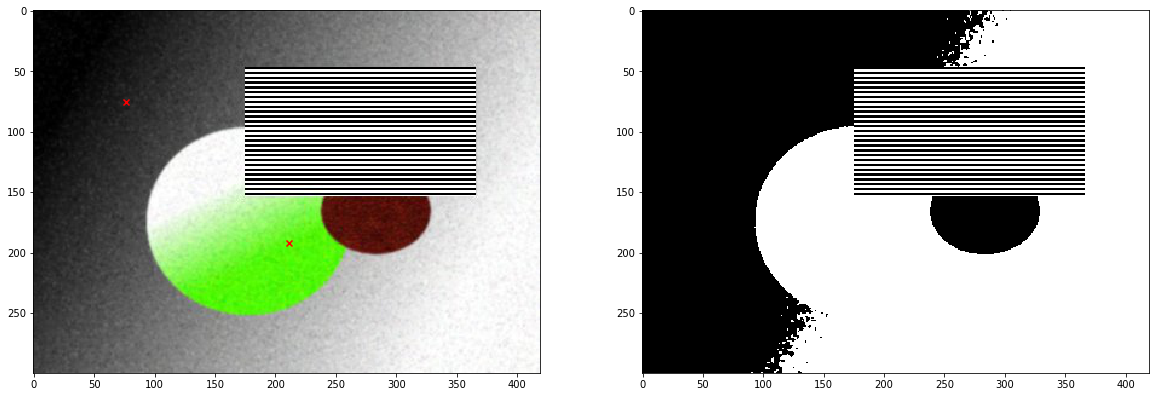

In [20]:
xp = spoints.xs
yp = spoints.ys

obj_seed_point = (int(xp[0]), int(yp[0]))
bkg_seed_point = (int(xp[1]), int(yp[1]))

segmentation = binary_segmentation(image, obj_seed_point, bkg_seed_point, K=10e4, s=0.5, LAMBDA=10)

%matplotlib inline
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.imshow(image)
plt.scatter(x=[obj_seed_point[0], bkg_seed_point[0]], y=[obj_seed_point[1], bkg_seed_point[1]], c='r', marker='x')

plt.subplot(1,2,2)
plt.imshow(segmentation, cmap='gray')

<IPython.core.display.Javascript object>


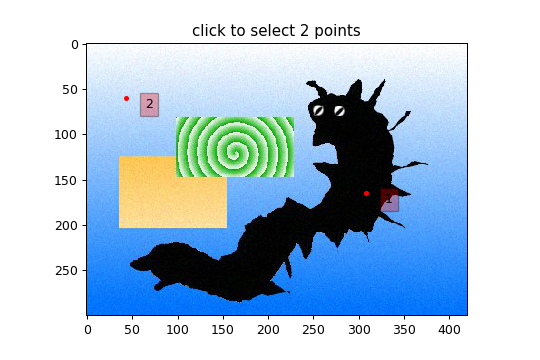

offset= 21.0


In [21]:
# load image
image = plt.imread('segtest2.jpg')

%matplotlib notebook
fig = plt.figure()
ax = fig.add_subplot(1,1,1) 
ax.imshow(image,cmap=plt.cm.gray)

#selectpoints will show the axis and wait for the specified # number of user clicks
k=2
spoints = select_k_points(ax,k)

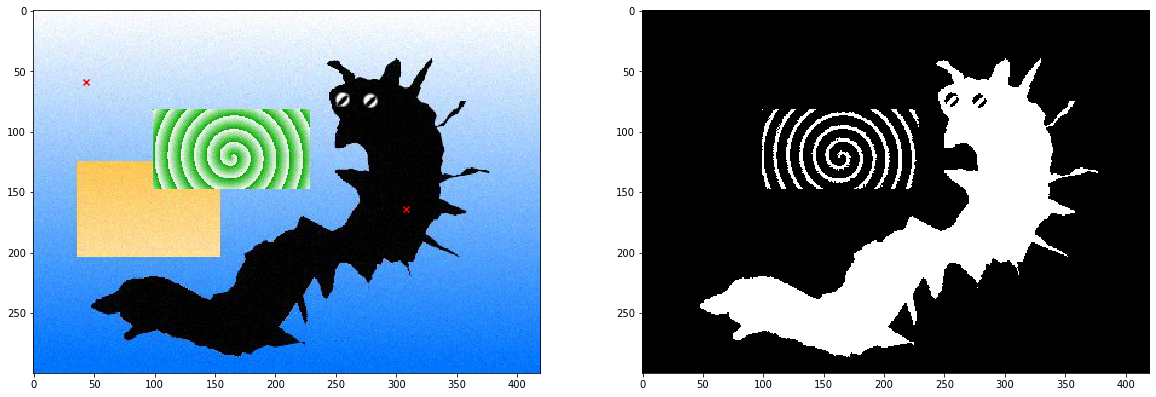

In [22]:
xp = spoints.xs
yp = spoints.ys

obj_seed_point = (int(xp[0]), int(yp[0]))
bkg_seed_point = (int(xp[1]), int(yp[1]))

segmentation = binary_segmentation(image, obj_seed_point, bkg_seed_point, K=10e4, s=0.5, LAMBDA=10)

%matplotlib inline
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.imshow(image)
plt.scatter(x=[obj_seed_point[0], bkg_seed_point[0]], y=[obj_seed_point[1], bkg_seed_point[1]], c='r', marker='x')

plt.subplot(1,2,2)
plt.imshow(segmentation, cmap='gray')

This is a binary segmentation problem. The algorithm did well for the first example (owl) where there was clearly just 1 foreground object and consistent background. As long as the the object seed point was somewhere on the owl and the background seed point in the black region, it gave more or less similar segments consistently.

In segtest1, the gradient background was divided into two different cuts. Depending on the selection of the seed points, the segmentation varied a lot. It consistently separate the maroon circle because the background near it is quite light and there is a clear boundary. With a good selection of object seed, the green circle may or may not be segmented correctly.  Similarly for segtest2. The black insect boundary was always detected.